## 1.半监督学习

### 自训练

Step 5: 没有高置信度样本，停止


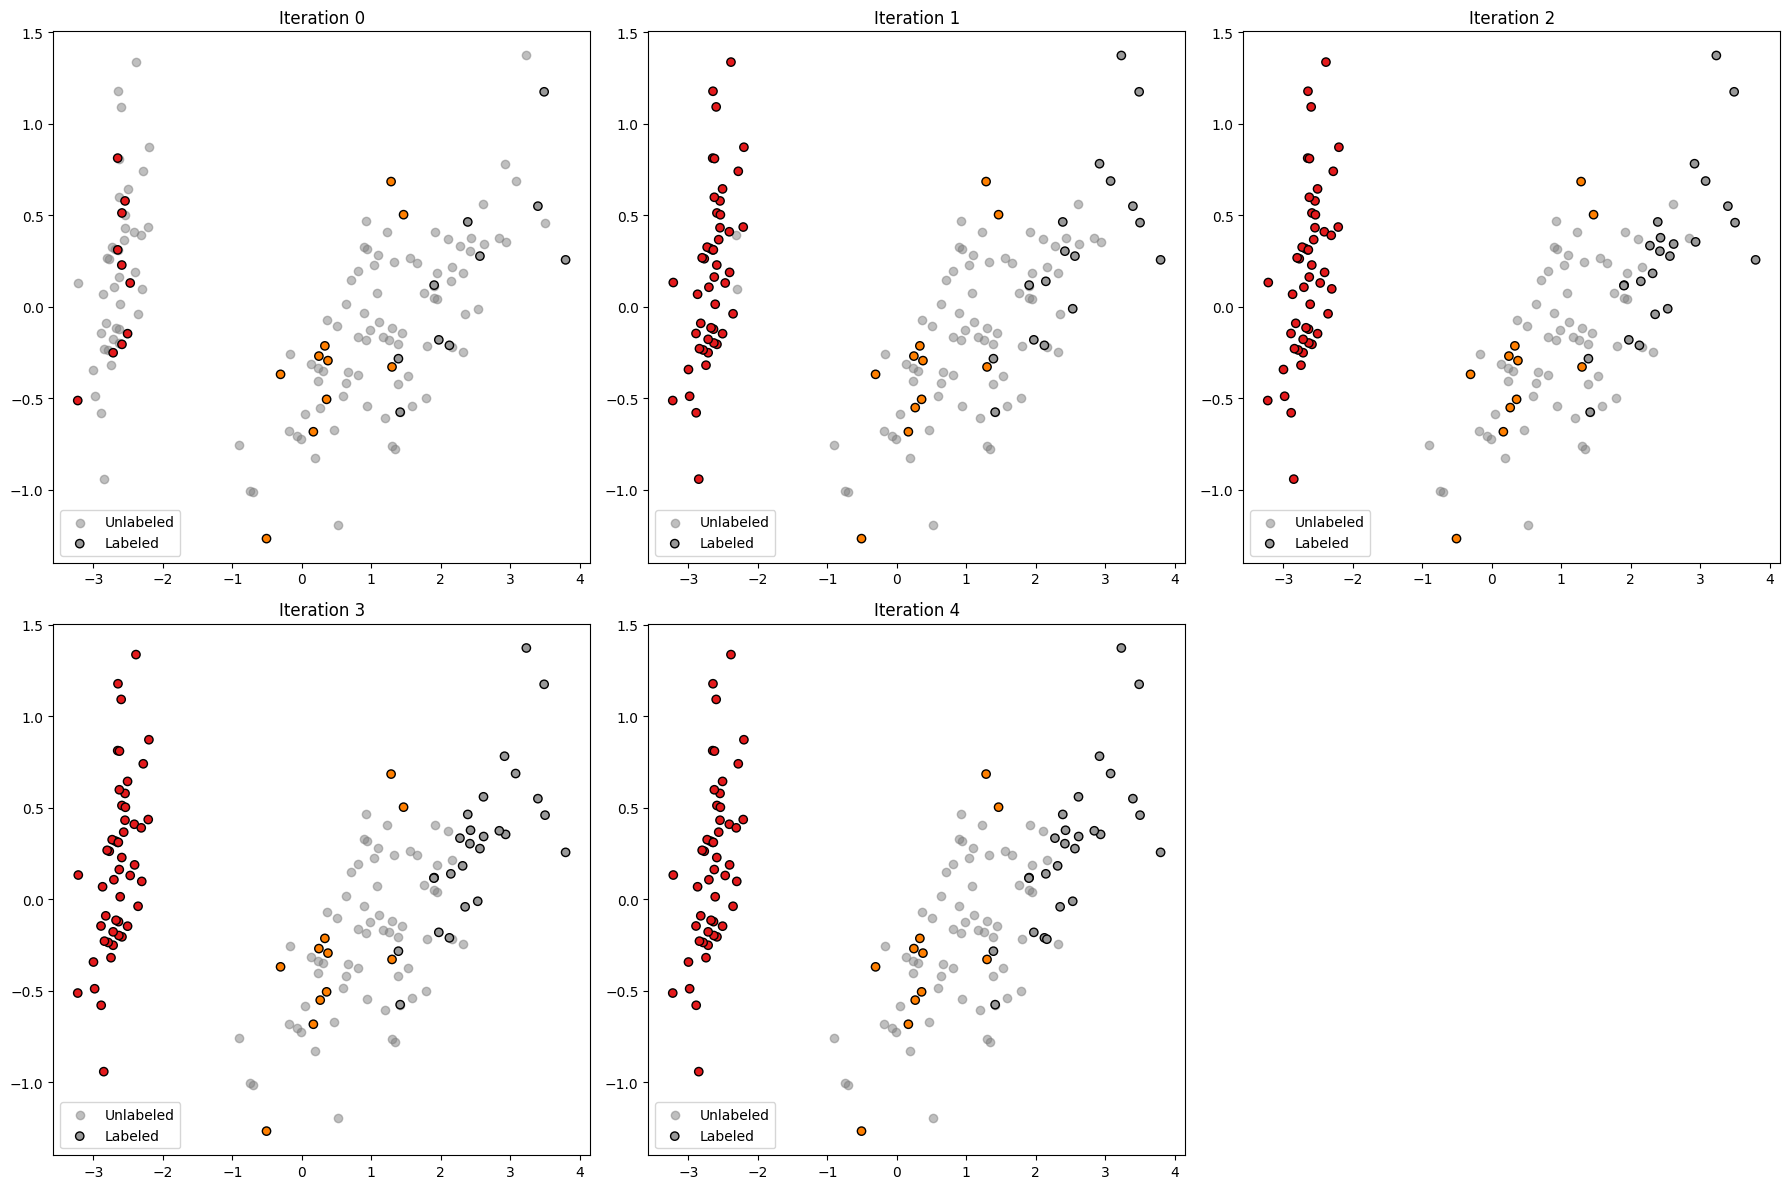

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# 1. 加载数据
X, y = load_iris(return_X_y=True)

# 随机挑选带标签样本，保证至少两个类别
X_labeled, X_unlabeled, y_labeled, y_unlabeled_true = train_test_split(
    X, y, train_size=30, stratify=y, random_state=42
)

# PCA 降维便于可视化
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
X_labeled_2d = pca.transform(X_labeled)
X_unlabeled_2d = pca.transform(X_unlabeled)

# 2. 初始训练
model = LogisticRegression(max_iter=200)
model.fit(X_labeled, y_labeled)

# 3. 保存每步状态用于绘图
history = [(X_labeled_2d.copy(), y_labeled.copy(), X_unlabeled_2d.copy())]

# 4. 自训练循环
for step in range(5):
    probs = model.predict_proba(X_unlabeled)
    pseudo_labels = probs.argmax(axis=1)
    confidences = probs.max(axis=1)
    mask = confidences > 0.9  # 高置信度样本
    
    if mask.sum() == 0:
        print(f"Step {step+1}: 没有高置信度样本，停止")
        break
    
    # 更新训练集
    X_labeled = np.vstack([X_labeled, X_unlabeled[mask]])
    y_labeled = np.concatenate([y_labeled, pseudo_labels[mask]])
    X_labeled_2d = np.vstack([X_labeled_2d, X_unlabeled_2d[mask]])
    
    X_unlabeled = X_unlabeled[~mask]
    X_unlabeled_2d = X_unlabeled_2d[~mask]
    
    # 重新训练模型
    model.fit(X_labeled, y_labeled)
    
    # 保存状态
    history.append((X_labeled_2d.copy(), y_labeled.copy(), X_unlabeled_2d.copy()))

# 5. 一次性绘制所有迭代步骤（最多 6 步，2×3 网格）
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (X_l, y_l, X_u) in enumerate(history):
    ax = axes[i]
    ax.scatter(X_u[:, 0], X_u[:, 1], c='gray', label='Unlabeled', alpha=0.5)
    sc = ax.scatter(X_l[:, 0], X_l[:, 1], c=y_l, cmap='Set1', edgecolor='k', label='Labeled')
    ax.set_title(f"Iteration {i}")
    ax.legend()

# 隐藏多余子图
for j in range(len(history), 6):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### 协同训练

Step 4: no confident samples, stop.


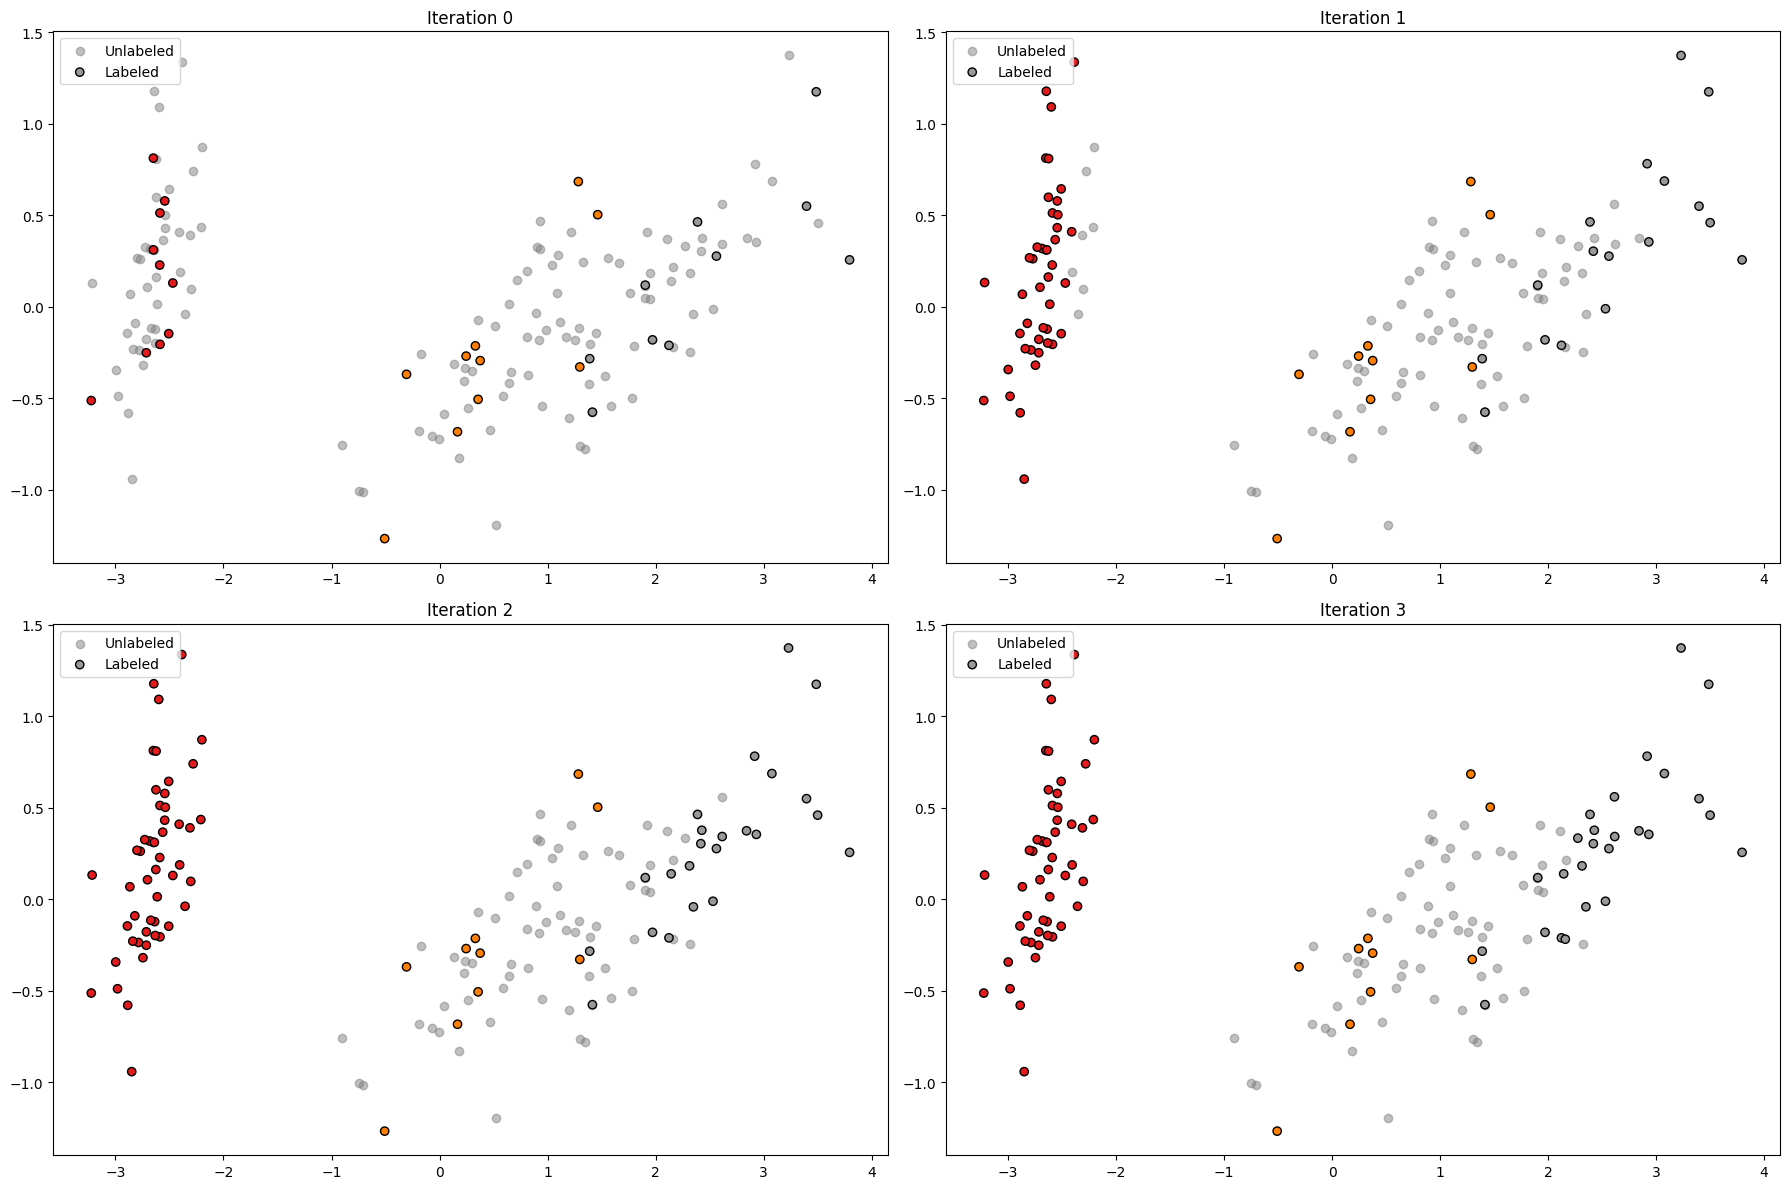

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# 1. 数据
X, y = load_iris(return_X_y=True)
X_labeled, X_unlabeled, y_labeled, y_unlabeled_true = train_test_split(
    X, y, train_size=30, stratify=y, random_state=42
)

# 2. PCA 可视化
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
X_labeled_2d = pca.transform(X_labeled)
X_unlabeled_2d = pca.transform(X_unlabeled)

# 3. 划分视图
X_labeled_view1 = X_labeled[:, :2]
X_labeled_view2 = X_labeled[:, 2:]
X_unlabeled_view1 = X_unlabeled[:, :2]
X_unlabeled_view2 = X_unlabeled[:, 2:]

# 4. 分类器
clf1 = LogisticRegression(max_iter=200)
clf2 = LogisticRegression(max_iter=200)
clf1.fit(X_labeled_view1, y_labeled)
clf2.fit(X_labeled_view2, y_labeled)

history = [(X_labeled_2d.copy(), y_labeled.copy(), X_unlabeled_2d.copy())]

# 5. 协同训练循环
for step in range(5):
    probs1 = clf1.predict_proba(X_unlabeled_view1)
    pseudo_labels1 = probs1.argmax(axis=1)
    confidences1 = probs1.max(axis=1)

    probs2 = clf2.predict_proba(X_unlabeled_view2)
    pseudo_labels2 = probs2.argmax(axis=1)
    confidences2 = probs2.max(axis=1)

    # 高置信度样本
    mask1 = confidences1 > 0.9
    mask2 = confidences2 > 0.9

    # 新增样本：确保不会重复
    new_mask = mask1 | mask2
    if new_mask.sum() == 0:
        print(f"Step {step+1}: no confident samples, stop.")
        break

    # 生成伪标签
    pseudo_labels = np.where(mask1, pseudo_labels1, pseudo_labels2)
    
    # 更新训练集
    X_labeled_view1 = np.vstack([X_labeled_view1, X_unlabeled_view1[new_mask]])
    X_labeled_view2 = np.vstack([X_labeled_view2, X_unlabeled_view2[new_mask]])
    X_labeled_2d = np.vstack([X_labeled_2d, X_unlabeled_2d[new_mask]])
    y_labeled = np.concatenate([y_labeled, pseudo_labels[new_mask]])

    # 移除已加入的未标注样本
    X_unlabeled_view1 = X_unlabeled_view1[~new_mask]
    X_unlabeled_view2 = X_unlabeled_view2[~new_mask]
    X_unlabeled_2d = X_unlabeled_2d[~new_mask]

    # 重新训练
    clf1.fit(X_labeled_view1, y_labeled)
    clf2.fit(X_labeled_view2, y_labeled)

    # 保存状态
    history.append((X_labeled_2d.copy(), y_labeled.copy(), X_unlabeled_2d.copy()))

# 6. 绘图 2x3 网格
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, (X_l, y_l, X_u) in enumerate(history):
    ax = axes[i]
    ax.scatter(X_u[:, 0], X_u[:, 1], c='gray', label='Unlabeled', alpha=0.5)
    ax.scatter(X_l[:, 0], X_l[:, 1], c=y_l, cmap='Set1', edgecolor='k', label='Labeled')
    ax.set_title(f"Iteration {i}")
    ax.legend()

for j in range(len(history), 4):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### 图半监督学习

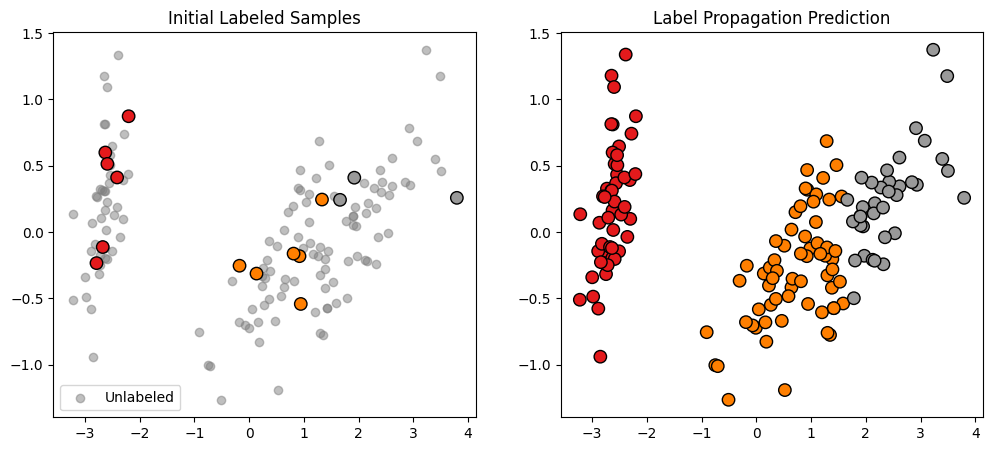

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.semi_supervised import LabelPropagation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# 1. 加载数据
X, y = load_iris(return_X_y=True)

# 2. 随机挑选带标签样本
rng = np.random.RandomState(42)
n_total = X.shape[0]
n_labeled = 15  # 只标注部分样本
indices = np.arange(n_total)
rng.shuffle(indices)

y_semi = -np.ones(n_total)  # 未标注样本用 -1 表示
y_semi[indices[:n_labeled]] = y[indices[:n_labeled]]

# 3. PCA 降维便于可视化
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# 4. 构建 LabelPropagation 模型
label_prop_model = LabelPropagation(kernel='rbf', gamma=20)
label_prop_model.fit(X, y_semi)

# 5. 预测所有样本
y_pred = label_prop_model.transduction_

# 6. 可视化结果
plt.figure(figsize=(12, 5))

# 原始带标签样本
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c='gray', alpha=0.5, label='Unlabeled')
plt.scatter(X_2d[indices[:n_labeled], 0], X_2d[indices[:n_labeled], 1], c=y[indices[:n_labeled]], cmap='Set1', edgecolor='k', s=80)
plt.title("Initial Labeled Samples")
plt.legend()

# Label Propagation 预测结果
plt.subplot(1, 2, 2)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_pred, cmap='Set1', edgecolor='k', s=80)
plt.title("Label Propagation Prediction")
plt.show()


## 2.强化学习

### 马尔可夫决策过程

最优策略：
[['S' '↓' '↓' '↓']
 ['↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '↓']
 ['→' '→' '→' 'T']]


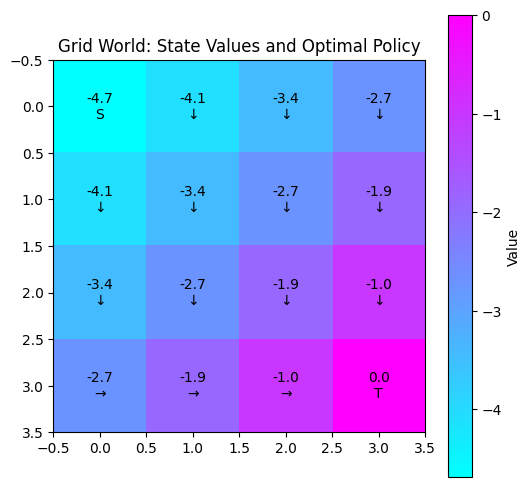

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 网格世界参数
n_rows, n_cols = 4, 4
n_states = n_rows * n_cols
n_actions = 4  # 上,下,左,右

action_offsets = [(-1,0),(1,0),(0,-1),(0,1)]
action_symbols = ['↑','↓','←','→']

start_state = 0       # 左上角 S
terminal_state = n_states - 1  # 右下角 T
reward_step = -1
reward_terminal = 0

# 状态转移函数
def next_state_reward(s, a):
    row, col = divmod(s, n_cols)
    if s == terminal_state:
        return s, reward_terminal
    dr, dc = action_offsets[a]
    new_row = min(max(row+dr,0), n_rows-1)
    new_col = min(max(col+dc,0), n_cols-1)
    s_next = new_row * n_cols + new_col
    return s_next, reward_step

# 2. 值迭代
gamma = 0.9
theta = 1e-4
V = np.zeros(n_states)

while True:
    delta = 0
    for s in range(n_states):
        if s == terminal_state:
            continue
        v = V[s]
        V[s] = max([next_state_reward(s,a)[1] + gamma*V[next_state_reward(s,a)[0]] for a in range(n_actions)])
        delta = max(delta, abs(v-V[s]))
    if delta < theta:
        break

# 3. 求最优策略
policy = np.full(n_states,'',dtype=object)
for s in range(n_states):
    if s == start_state:
        policy[s] = 'S'
    elif s == terminal_state:
        policy[s] = 'T'
    else:
        q_values = [next_state_reward(s,a)[1] + gamma*V[next_state_reward(s,a)[0]] for a in range(n_actions)]
        policy[s] = action_symbols[np.argmax(q_values)]

grid_policy = policy.reshape(n_rows, n_cols)
print("最优策略：")
print(grid_policy)

# 4. 可视化值函数和策略
plt.figure(figsize=(6,6))
plt.imshow(V.reshape(n_rows, n_cols), cmap='cool', interpolation='nearest')
for i in range(n_rows):
    for j in range(n_cols):
        plt.text(j,i,f"{V[i*n_cols+j]:.1f}\n{grid_policy[i,j]}",ha='center',va='center',color='black')
plt.title("Grid World: State Values and Optimal Policy")
plt.colorbar(label="Value")
plt.show()


### 动态规划与值迭代

最优策略：
[['S' '↓' '↓' '↓']
 ['↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '↓']
 ['→' '→' '→' 'T']]


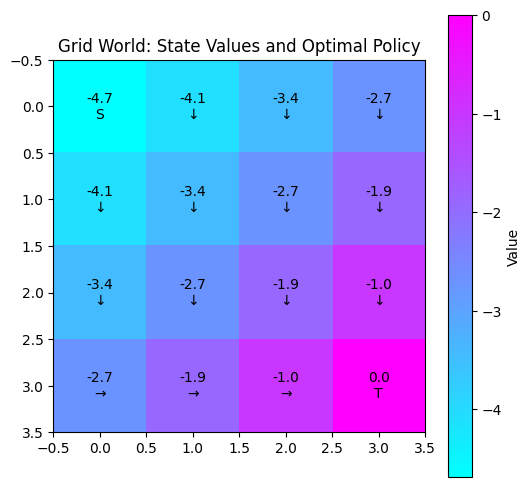

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 网格世界参数
n_rows, n_cols = 4, 4
n_states = n_rows * n_cols
n_actions = 4  # 上,下,左,右
action_offsets = [(-1,0),(1,0),(0,-1),(0,1)]
action_symbols = ['↑','↓','←','→']

start_state = 0
terminal_state = n_states-1
reward_step = -1
reward_terminal = 0
gamma = 0.9
theta = 1e-4

def next_state_reward(s,a):
    row,col = divmod(s,n_cols)
    if s==terminal_state:
        return s, reward_terminal
    dr,dc = action_offsets[a]
    new_row = min(max(row+dr,0),n_rows-1)
    new_col = min(max(col+dc,0),n_cols-1)
    s_next = new_row*n_cols+new_col
    return s_next, reward_step

# 值迭代
V = np.zeros(n_states)
while True:
    delta = 0
    for s in range(n_states):
        if s==terminal_state:
            continue
        v = V[s]
        V[s] = max([next_state_reward(s,a)[1]+gamma*V[next_state_reward(s,a)[0]] for a in range(n_actions)])
        delta = max(delta, abs(v-V[s]))
    if delta<theta:
        break

# 导出最优策略
policy = np.full(n_states,'',dtype=object)
for s in range(n_states):
    if s==start_state:
        policy[s]='S'
    elif s==terminal_state:
        policy[s]='T'
    else:
        q_values = [next_state_reward(s,a)[1]+gamma*V[next_state_reward(s,a)[0]] for a in range(n_actions)]
        policy[s]=action_symbols[np.argmax(q_values)]

grid_policy = policy.reshape(n_rows,n_cols)
print("最优策略：")
print(grid_policy)

# 可视化值函数和策略
plt.figure(figsize=(6,6))
plt.imshow(V.reshape(n_rows,n_cols), cmap='cool', interpolation='nearest')
for i in range(n_rows):
    for j in range(n_cols):
        plt.text(j,i,f"{V[i*n_cols+j]:.1f}\n{grid_policy[i,j]}",ha='center',va='center',color='black')
plt.title("Grid World: State Values and Optimal Policy")
plt.colorbar(label="Value")
plt.show()

### Q-Learning

最优策略：
[['S' '↓' '→' '↓']
 ['↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '↓']
 ['→' '→' '→' 'T']]


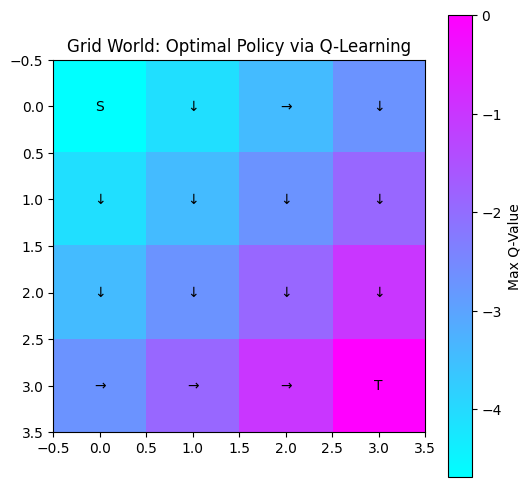

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 网格世界参数
n_rows, n_cols = 4, 4
n_states = n_rows * n_cols
n_actions = 4  # 上,下,左,右
action_offsets = [(-1,0),(1,0),(0,-1),(0,1)]
action_symbols = ['↑','↓','←','→']

start_state = 0
terminal_state = n_states-1
reward_step = -1
reward_terminal = 0

gamma = 0.9
alpha = 0.1
epsilon = 0.1
n_episodes = 5000

def next_state_reward(s,a):
    row,col = divmod(s,n_cols)
    if s==terminal_state:
        return s,reward_terminal
    dr,dc = action_offsets[a]
    new_row = min(max(row+dr,0),n_rows-1)
    new_col = min(max(col+dc,0),n_cols-1)
    s_next = new_row*n_cols+new_col
    return s_next,reward_step

# 初始化 Q 表
Q = np.zeros((n_states,n_actions))

# Q-Learning 主循环
for episode in range(n_episodes):
    s = start_state
    while s != terminal_state:
        if np.random.rand() < epsilon:
            a = np.random.randint(n_actions)
        else:
            a = np.argmax(Q[s, :])
        s_next, r = next_state_reward(s, a)
        Q[s, a] += alpha * (r + gamma * np.max(Q[s_next, :]) - Q[s, a])
        s = s_next

# 导出最优策略
policy = np.full(n_states,'',dtype=object)
for s in range(n_states):
    if s==start_state:
        policy[s]='S'
    elif s==terminal_state:
        policy[s]='T'
    else:
        policy[s] = action_symbols[np.argmax(Q[s, :])]

# reshape 成二维数组
grid_policy = policy.reshape((n_rows,n_cols))
print("最优策略：")
print(grid_policy)

# 可视化
plt.figure(figsize=(6,6))
plt.imshow(np.max(Q,axis=1).reshape(n_rows,n_cols), cmap='cool', interpolation='nearest')
for i in range(n_rows):
    for j in range(n_cols):
        plt.text(j,i,f"{grid_policy[i,j]}",ha='center',va='center',color='black')
plt.title("Grid World: Optimal Policy via Q-Learning")
plt.colorbar(label="Max Q-Value")
plt.show()
